In [31]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import sklearn
import warnings

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import utils
import ml_functions
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn import (
    linear_model, 
    ensemble,
    tree,
    decomposition, 
    naive_bayes, 
    neural_network,
    svm,
    metrics,
    preprocessing, 
    model_selection, 
    pipeline,
)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, learning_curve
import warnings
from sklearn.exceptions import ConvergenceWarning
from imblearn.pipeline import make_pipeline as make_imb_pipeline
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from tqdm import tqdm
from time import time
from sklearn.model_selection import StratifiedKFold, LeaveOneOut, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

## Load the data & Préprocessing

In [32]:
fname = "./datasets/AFDpresidentutf8/corpus.tache1.learn.utf8"
alltxts,alllabs = utils.load_pres(fname)


In [33]:
locuteurs_df = pd.DataFrame()
locuteurs_df['text'] = alltxts
locuteurs_df['label'] = alllabs

In [34]:
preprocessed_alltxts = [utils.preprocess(alltxt) for alltxt in locuteurs_df.text]

preprocessed_locuteurs_df = pd.DataFrame()
preprocessed_locuteurs_df['text'] = preprocessed_alltxts
preprocessed_locuteurs_df['label'] = alllabs

preprocessed_locuteurs_df.describe


<bound method NDFrame.describe of                                                     text  label
0       quand je dis chers amis il ne sagit pas la du...      1
1       dabord merci de cet exceptionnel accueil que ...      1
2       cest toujours tres emouvant de venir en afriq...      1
3       aucun citoyen francais ne peut etre indiffere...      1
4       le congo que naguere le nom qualifia de refug...      1
...                                                  ...    ...
57408              je suis heureux de le mener avec vous      1
57409   vous le savez comme vous jai la passion de la...      1
57410                             je crois en son avenir      1
57411   je crois en la politique cestadire en notre c...      1
57412                                 je compte sur vous      1

[57413 rows x 2 columns]>

In [35]:
# Mélange des données
preprocessed_locuteurs_df = preprocessed_locuteurs_df.sample(frac=1, random_state=42)

preprocessed_locuteurs_df.describe

<bound method NDFrame.describe of                                                     text  label
45008   de mener a bien dans lequite dans le dialogue...      1
5011                            tout cela nest pas exact      1
31032   cest tout le merite du maitre douvrage et des...      1
31493   a lenraciner dans les esprits et dans les coeurs      1
1270    nos deux pays qui travaillent la main dans la...      1
...                                                  ...    ...
54343   et puis nous devons egalement etre porteurs d...      1
38158                      il les impose trop lourdement      1
860                         dautres figures lont marquee      1
15795   avec le gouvernement que jai constitue et qui...     -1
56422   il faut dabord examiner les problemes du cont...     -1

[57413 rows x 2 columns]>

In [36]:
print(len(preprocessed_locuteurs_df['text']))
print(len(preprocessed_locuteurs_df['label']))

57413
57413


In [37]:
X, X_test, y, y_test = model_selection.train_test_split(preprocessed_locuteurs_df['text'], preprocessed_locuteurs_df['label'], test_size=0.2, random_state=24, stratify= preprocessed_locuteurs_df['label'])

# Evaluations du temps d'apprentissage

On définie des tailles pour le vocabulaires

In [38]:
vocab_sizes = [10, 100, 1000, 10000, 20000, 40000, 50000, 80000, 100000]

Récupération des différents jeux de données en fonctions des tailles de vocabulaires

In [39]:
datasets = {}

for len_voc in vocab_sizes:
    # On applique les stops words et on limite la taille du vocabulaire a len_voc
    cv = CountVectorizer(stop_words=stopwords.words('french'), max_features=len_voc)

    X = cv.fit_transform(preprocessed_locuteurs_df['text'])
    y = preprocessed_locuteurs_df['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

    datasets[len_voc] = [X_resampled, X_test, y_resampled, y_test]

### Evaluation d'un modele de Regression logistique

### Entrainement

In [121]:
import time as tm

times_rl = []
accuracy_rl = []
f1_score_rl = []
balanced_accuracy_rl = []

for s in vocab_sizes:
    X_train, X_test, y_train, y_test = datasets[s]

    clf = linear_model.LogisticRegression()
    t = tm.time()
    clf.fit(X_train, y_train)
    t = (tm.time() - t) * 1000

    y_pred = clf.predict(X_test)

    acc = metrics.accuracy_score(y_pred, y_test)
    f1 = metrics.f1_score(y_pred, y_test)
    balanced_acc = metrics.balanced_accuracy_score(y_pred, y_test)

    times_rl.append(t)
    accuracy_rl.append(acc)
    f1_score_rl.append(f1)
    balanced_accuracy_rl.append(balanced_acc)

    print('Vocabulary Size:', s)
    print('Learning Time:', t, 'ms')
    print('Accuracy:', acc)
    print('F1 Score:', f1)
    print('Balanced Accuracy:', balanced_acc)
    print('')

Vocabulary Size: 10
Learning Time: 6.018400192260742 ms
Accuracy: 0.6953757728816511
F1 Score: 0.8092693565976009
Balanced Accuracy: 0.5330358950673189

Vocabulary Size: 100
Learning Time: 10.858774185180664 ms
Accuracy: 0.7033876164765305
F1 Score: 0.8094438849725859
Balanced Accuracy: 0.5744847605978336

Vocabulary Size: 1000
Learning Time: 23.281335830688477 ms
Accuracy: 0.7367412697030393
F1 Score: 0.8306157897685885
Balanced Accuracy: 0.6151038910654343

Vocabulary Size: 10000
Learning Time: 122.70736694335938 ms
Accuracy: 0.7678307062614299
F1 Score: 0.8522009091917064
Balanced Accuracy: 0.641558507729917

Vocabulary Size: 20000
Learning Time: 143.89348030090332 ms
Accuracy: 0.771227031263607
F1 Score: 0.8546128728761968
Balanced Accuracy: 0.6440508920799354

Vocabulary Size: 40000
Learning Time: 158.50186347961426 ms
Accuracy: 0.7734041626752591
F1 Score: 0.8562748563853292
Balanced Accuracy: 0.6448911388041956

Vocabulary Size: 50000
Learning Time: 167.37818717956543 ms
Accurac

### Résultat

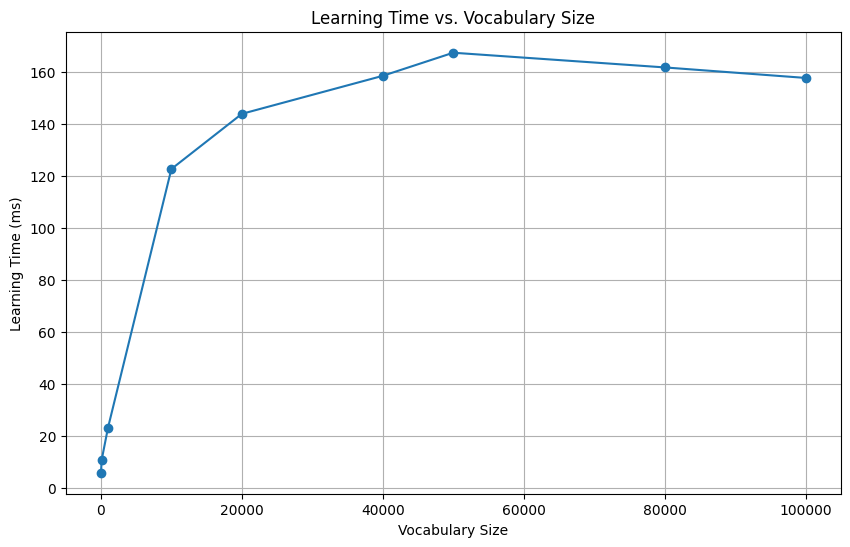

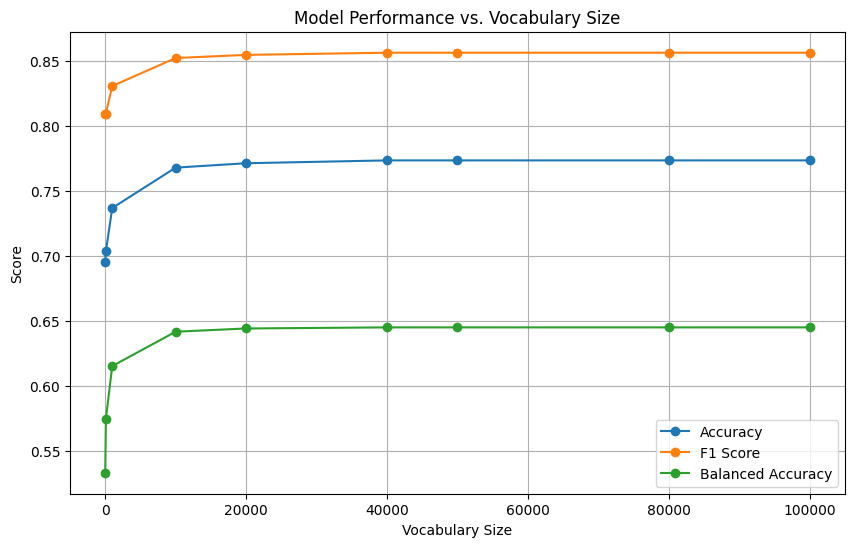

In [122]:
# Plotting the learning time
plt.figure(figsize=(10, 6))
plt.plot(vocab_sizes, times_rl, marker='o')
plt.xlabel('Vocabulary Size')
plt.ylabel('Learning Time (ms)')
plt.title('Learning Time vs. Vocabulary Size')
plt.grid(True)
plt.show()

# Plotting the accuracy, F1 score, and balanced accuracy
plt.figure(figsize=(10, 6))
plt.plot(vocab_sizes, accuracy_rl, marker='o', label='Accuracy')
plt.plot(vocab_sizes, f1_score_rl, marker='o', label='F1 Score')
plt.plot(vocab_sizes, balanced_accuracy_rl, marker='o', label='Balanced Accuracy')
plt.xlabel('Vocabulary Size')
plt.ylabel('Score')
plt.title('Model Performance vs. Vocabulary Size')
plt.legend()
plt.grid(True)
plt.show()

### Evaluation d'un modele SVM

### Entraintement

In [78]:
times_svm = []
accuracy_svm = []
f1_score_svm = []
balanced_accuracy_svm = []


for s in vocab_sizes:
    X_train, X_test, y_train, y_test = datasets[s]

    clf = svm.SVC()
    t = tm.time()
    clf.fit(X_train, y_train)
    t = (tm.time() - t) * 1000
    

    y_pred = clf.predict(X_test)

    acc = metrics.accuracy_score(y_pred, y_test)
    f1 = metrics.f1_score(y_pred, y_test)
    balanced_acc = metrics.balanced_accuracy_score(y_pred, y_test)

    times_svm.append(t)
    accuracy_svm.append(acc)
    f1_score_svm.append(f1)
    balanced_accuracy_svm.append(balanced_acc)
    
    print('\tVocabulary Size \t:', s)
    print('\tLearning Time \t\t:', t)
    print('\tAccuracy \t\t:', acc)
    print('\tF1 Score \t\t:', f1)
    print('\tBalanced accuracy \t:', balanced_acc)
    print('')

	Vocabulary Size 	: 10
	Learning Time 		: 2445.077419281006
	Accuracy 		: 0.7002525472437516
	F1 Score 		: 0.8134619553435942
	Balanced accuracy 	: 0.5309043261082357

	Vocabulary Size 	: 100
	Learning Time 		: 4676.778316497803
	Accuracy 		: 0.713576591483062
	F1 Score 		: 0.8180963442287484
	Balanced accuracy 	: 0.573493886341071

	Vocabulary Size 	: 1000
	Learning Time 		: 9172.197580337524
	Accuracy 		: 0.740747191500479
	F1 Score 		: 0.8336778590982736
	Balanced accuracy 	: 0.6168669039893817

	Vocabulary Size 	: 10000
	Learning Time 		: 16800.772190093994
	Accuracy 		: 0.7605155447182792
	F1 Score 		: 0.8474256546826454
	Balanced accuracy 	: 0.6335007392327371

	Vocabulary Size 	: 20000
	Learning Time 		: 18519.654989242554
	Accuracy 		: 0.7588609248454237
	F1 Score 		: 0.8461923012831195
	Balanced accuracy 	: 0.6326421391203761

	Vocabulary Size 	: 40000
	Learning Time 		: 18547.268867492676
	Accuracy 		: 0.758164242793695
	F1 Score 		: 0.8456793553764935
	Balanced accuracy 	: 0

### Resultat

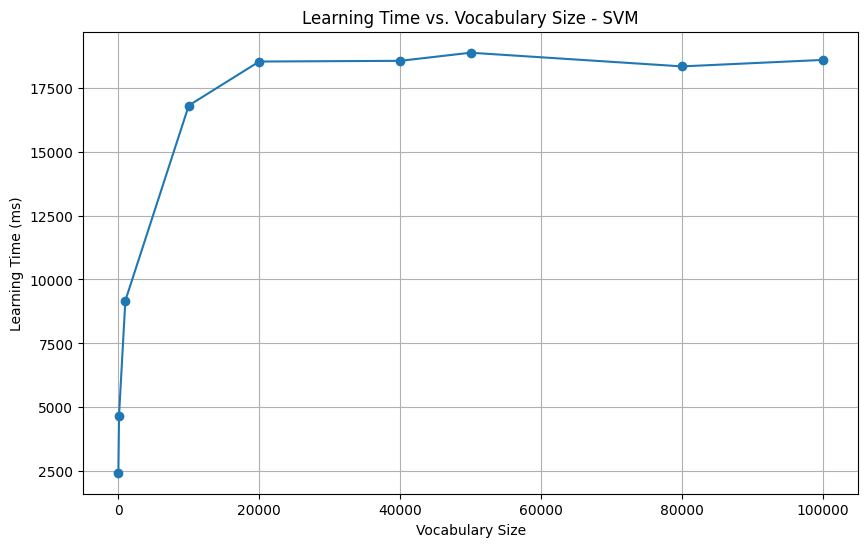

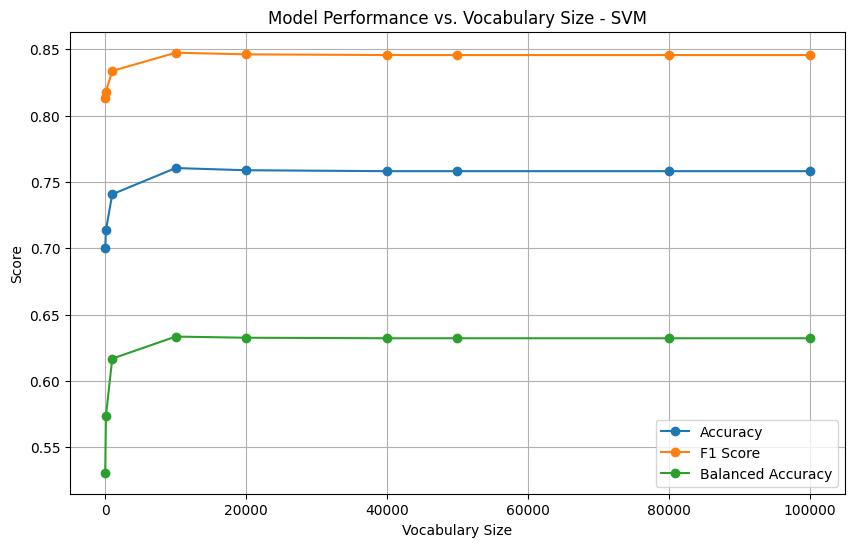

In [79]:
# Plotting the learning time
plt.figure(figsize=(10, 6))
plt.plot(vocab_sizes, times_svm, marker='o')
plt.xlabel('Vocabulary Size')
plt.ylabel('Learning Time (ms)')
plt.title('Learning Time vs. Vocabulary Size - SVM')
plt.grid(True)
plt.show()

# Plotting the accuracy, F1 score, and balanced accuracy
plt.figure(figsize=(10, 6))
plt.plot(vocab_sizes, accuracy_svm, marker='o', label='Accuracy')
plt.plot(vocab_sizes, f1_score_svm, marker='o', label='F1 Score')
plt.plot(vocab_sizes, balanced_accuracy_svm, marker='o', label='Balanced Accuracy')
plt.xlabel('Vocabulary Size')
plt.ylabel('Score')
plt.title('Model Performance vs. Vocabulary Size - SVM')
plt.legend()
plt.grid(True)
plt.show()

### Evaluation d'un modele Naives Baies

#### Entrainement

In [147]:
times_nv = []
accuracy_nv = []
f1_score_nv = []
balanced_accuracy_nv = []

for s in vocab_sizes:
    X_train, X_test, y_train, y_test = datasets[s]

    clf = naive_bayes.MultinomialNB()
    
    t = tm.time()
    clf.fit(X_train, y_train)
    t = (tm.time() - t) * 1000

    y_pred = clf.predict(X_test)

    acc = metrics.accuracy_score(y_pred, y_test)
    f1 = metrics.f1_score(y_pred, y_test)
    balanced_acc = metrics.balanced_accuracy_score(y_pred, y_test)

    times_nv.append(t)
    accuracy_nv.append(acc)
    f1_score_nv.append(f1)
    balanced_accuracy_nv.append(balanced_acc)

    print('\tVocabulary Size \t:', s)
    print('\tLearning Time \t\t:', t)
    print('\tAccuracy \t\t:', acc)
    print('\tF1 Score \t\t:', f1)
    print('\tBalanced accuracy \t:', balanced_acc)
    print('')

	Vocabulary Size 	: 10
	Learning Time 		: 2.000093460083008
	Accuracy 		: 0.41861882783244797
	F1 Score 		: 0.5304543536362357
	Balanced accuracy 	: 0.5119877717880275

	Vocabulary Size 	: 100
	Learning Time 		: 2.003192901611328
	Accuracy 		: 0.595488983715057
	F1 Score 		: 0.7145578565722362
	Balanced accuracy 	: 0.558070140358001

	Vocabulary Size 	: 1000
	Learning Time 		: 1.0001659393310547
	Accuracy 		: 0.7075677087869023
	F1 Score 		: 0.8060304990757856
	Balanced accuracy 	: 0.6126240844163684

	Vocabulary Size 	: 10000
	Learning Time 		: 2.000093460083008
	Accuracy 		: 0.7545937472785857
	F1 Score 		: 0.8403218495013599
	Balanced accuracy 	: 0.6464278441231064

	Vocabulary Size 	: 20000
	Learning Time 		: 2.5081634521484375
	Accuracy 		: 0.7536358094574589
	F1 Score 		: 0.8393982401362475
	Balanced accuracy 	: 0.6470671950084252

	Vocabulary Size 	: 40000
	Learning Time 		: 2.505779266357422
	Accuracy 		: 0.7457981363755116
	F1 Score 		: 0.8332476435304199
	Balanced accuracy 	:

#### Résultats

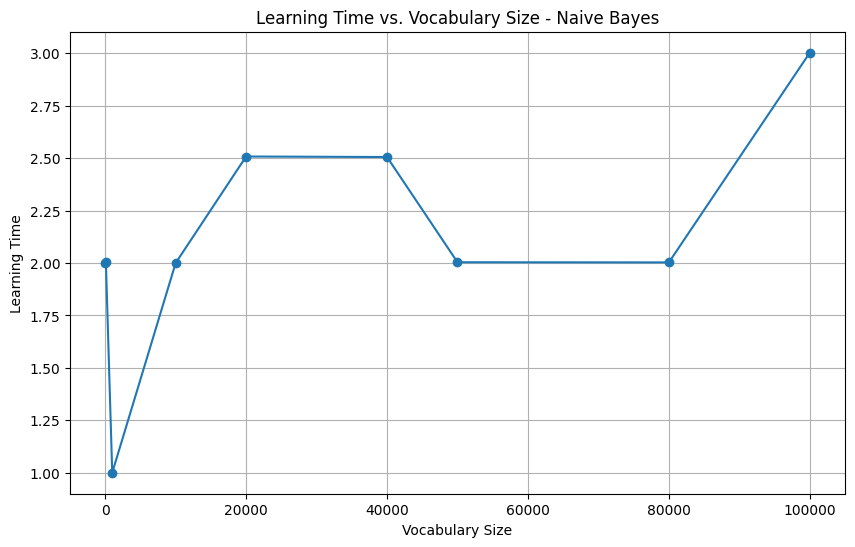

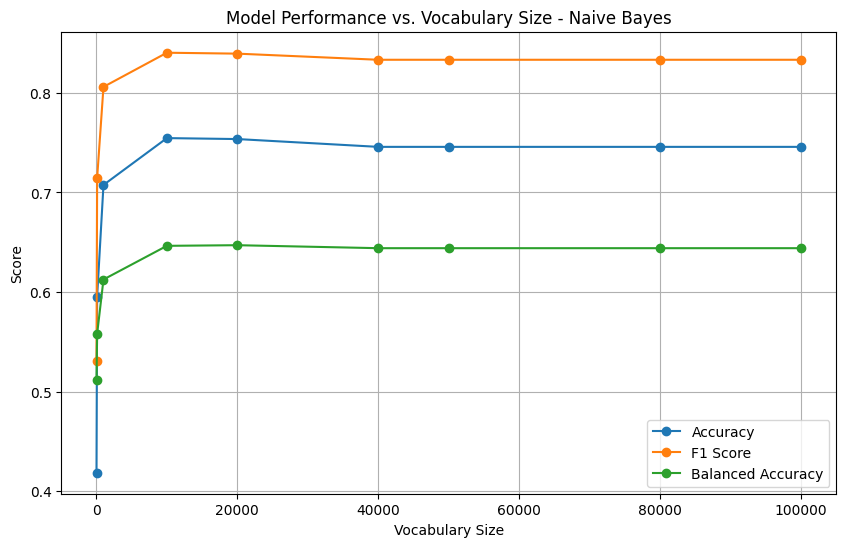

In [148]:
# Plotting the learning time
plt.figure(figsize=(10, 6))
plt.plot(vocab_sizes, times_nv, marker='o')
plt.xlabel('Vocabulary Size')
plt.ylabel('Learning Time')
plt.title('Learning Time vs. Vocabulary Size - Naive Bayes')
plt.grid(True)
plt.show()

# Plotting the accuracy, F1 score, and balanced accuracy
plt.figure(figsize=(10, 6))
plt.plot(vocab_sizes, accuracy_nv, marker='o', label='Accuracy')
plt.plot(vocab_sizes, f1_score_nv, marker='o', label='F1 Score')
plt.plot(vocab_sizes, balanced_accuracy_nv, marker='o', label='Balanced Accuracy')
plt.xlabel('Vocabulary Size')
plt.ylabel('Score')
plt.title('Model Performance vs. Vocabulary Size - Naive Bayes')
plt.legend()
plt.grid(True)
plt.show()

# Comparaison des modèles 

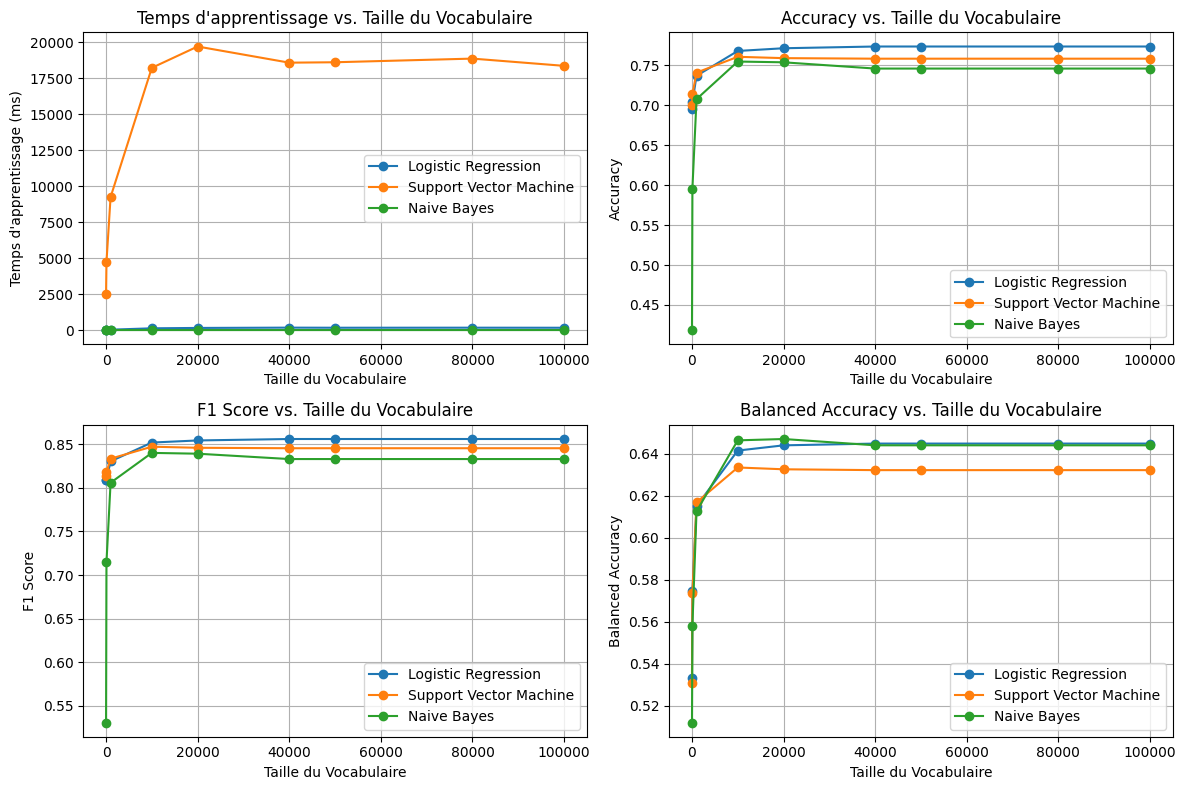

In [46]:
# Création de la grille
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Learning Time
axs[0, 0].plot(vocab_sizes, times_rl, marker='o', label='Logistic Regression')
axs[0, 0].plot(vocab_sizes, times_svm, marker='o', label='Support Vector Machine')
axs[0, 0].plot(vocab_sizes, times_nv, marker='o', label='Naive Bayes')
axs[0, 0].set_xlabel('Taille du Vocabulaire')
axs[0, 0].set_ylabel('Temps d\'apprentissage (ms)')
axs[0, 0].set_title('Temps d\'apprentissage vs. Taille du Vocabulaire')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Accuracy
axs[0, 1].plot(vocab_sizes, accuracy_rl, marker='o', label='Logistic Regression')
axs[0, 1].plot(vocab_sizes, accuracy_svm, marker='o', label='Support Vector Machine')
axs[0, 1].plot(vocab_sizes, accuracy_nv, marker='o', label='Naive Bayes')
axs[0, 1].set_xlabel('Taille du Vocabulaire')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].set_title('Accuracy vs. Taille du Vocabulaire')
axs[0, 1].legend()
axs[0, 1].grid(True)

# F1 Score
axs[1, 0].plot(vocab_sizes, f1_score_rl, marker='o', label='Logistic Regression')
axs[1, 0].plot(vocab_sizes, f1_score_svm, marker='o', label='Support Vector Machine')
axs[1, 0].plot(vocab_sizes, f1_score_nv, marker='o', label='Naive Bayes')
axs[1, 0].set_xlabel('Taille du Vocabulaire')
axs[1, 0].set_ylabel('F1 Score')
axs[1, 0].set_title('F1 Score vs. Taille du Vocabulaire')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Balanced Accuracy
axs[1, 1].plot(vocab_sizes, balanced_accuracy_rl, marker='o', label='Logistic Regression')
axs[1, 1].plot(vocab_sizes, balanced_accuracy_svm, marker='o', label='Support Vector Machine')
axs[1, 1].plot(vocab_sizes, balanced_accuracy_nv, marker='o', label='Naive Bayes')
axs[1, 1].set_xlabel('Taille du Vocabulaire')
axs[1, 1].set_ylabel('Balanced Accuracy')
axs[1, 1].set_title('Balanced Accuracy vs. Taille du Vocabulaire')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Ajuster les espacements entre les sous-graphiques
plt.tight_layout()

# Afficher la grille
plt.show()